In the following code, we download trajectory data from envirocar.org and plot it with its trajectory graph.

ele is not a valid column in input nodes. Ignoring this column.
timestamp is not a valid column in input nodes. Ignoring this column.
sat is not a valid column in input nodes. Ignoring this column.


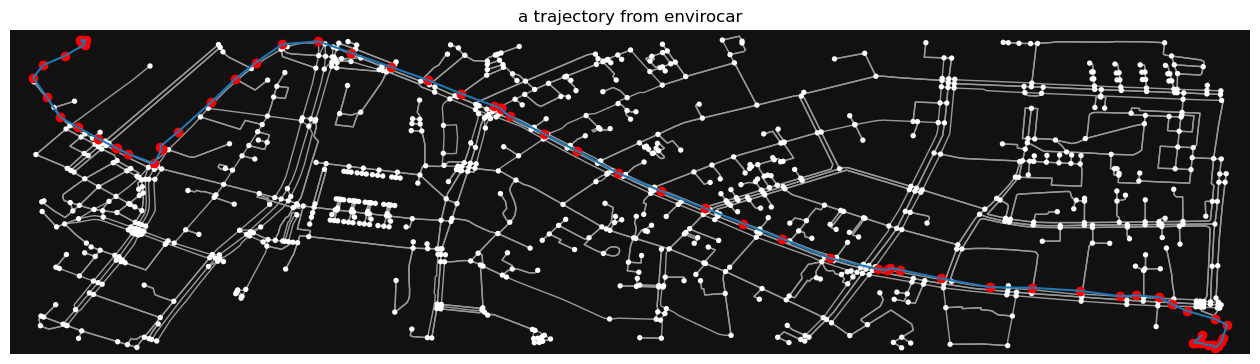

In [1]:
import json
import random

import geopandas as gpd
import networkx as nx
import osmnx as ox
import pandas as pd
import requests
from algorithms import mm_utils
from shapely.geometry import Point, shape


def plot_trajectory(
    trajectory, title=None, plot_trajectory_edges=True, plot_clusters=False
):
    """
    Plot trajectory points.
    Args:
        trajectory: a GeoDataFrame object which represents trajectory points.
        title: the title of the plot
    """
    # Get the bounding box
    bbox = gdf.total_bounds

    # 'total_bounds' returns a tuple with (minx, miny, maxx, maxy) values
    minx, miny, maxx, maxy = bbox

    # Download a map by specifying the bounding box, and draw the graph
    try:
        G = ox.graph.graph_from_bbox(
            maxy, miny, maxx, minx, network_type="all_private"
        )  # The order is north, south, east, west [https://osmnx.readthedocs.io/en/stable/user-reference.html#osmnx.graph.graph_from_bbox]
    except (ValueError, nx.NetworkXPointlessConcept) as e:
        # TODO: Often a "ValueError: Found no graph nodes within the requested polygon" error or
        #       "NetworkXPointlessConcept: Connectivity is undefined for the null graph" error happens.
        #       This should be fixed if possible.
        print(e)
        return
    fig, ax = ox.plot_graph(G, figsize=(16, 16), show=False, close=False)

    # Set the title of ax
    ax.set_title(title)

    if plot_trajectory_edges:
        # Plot the trajectory edges
        tripdata_edges = mm_utils.point_to_traj(
            gdf, columns={"ele": "average", "timestamp": "first", "sat": "first"}
        )
        tripdata_edges.plot(ax=ax, linewidth=1.5)

    if plot_clusters:
        # Get unique cluster labels
        unique_labels = gdf["cluster"].unique()

        # Generate a random color for each unique cluster label
        color_mapping = {
            label: "#" + "%06x" % random.randint(0, 0xFFFFFF) for label in unique_labels
        }

        for cluster_label in unique_labels:
            cluster_points = gdf[gdf["cluster"] == cluster_label]
            color = color_mapping[cluster_label]
            cluster_points.plot(
                ax=ax, markersize=5, color=color, label=f"Cluster {cluster_label}"
            )
    else:
        # Plot the trajectory points
        gdf.plot(ax=ax, color="red")

    # Draw the whole plot in the campus!
    campus = ox.features.features_from_place("Somewhere", tags={"name": True})
    campus.plot(ax=ax, alpha=0.5)


def download_from_envirocar(url):
    """
    Download trajectory data from envirocar.org.

    Args:
        url: a url of envirocar.org

    Returns:
        GeoDataFrame: trajectory data
    """

    # Download trajectory data from envirocar.org.
    response = requests.get(url)
    data = json.loads(response.text)

    # Convert the data into a GeoDataFrame
    geometries = []
    attributes = []
    for feature in data["features"]:
        geometry = shape(feature["geometry"])
        geometries.append(geometry)
        attributes.append(feature["properties"])

    return gpd.GeoDataFrame(data=attributes, geometry=geometries)


# Download trajectory data from envirocar
url = "https://envirocar.org/api/stable/tracks/52f3836be4b0d8e8c27ed6f0"
gdf = download_from_envirocar(url)

# Plot
plot_trajectory(gdf, "a trajectory from envirocar")

In the following code, we download GPS traces from Open Street Map, cluster it by using the DBSCAN algorithm, and then plot the result.

  0%|          | 0/32 [00:00<?, ?it/s]

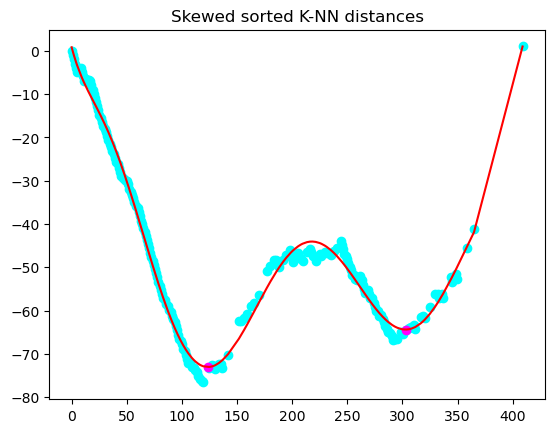

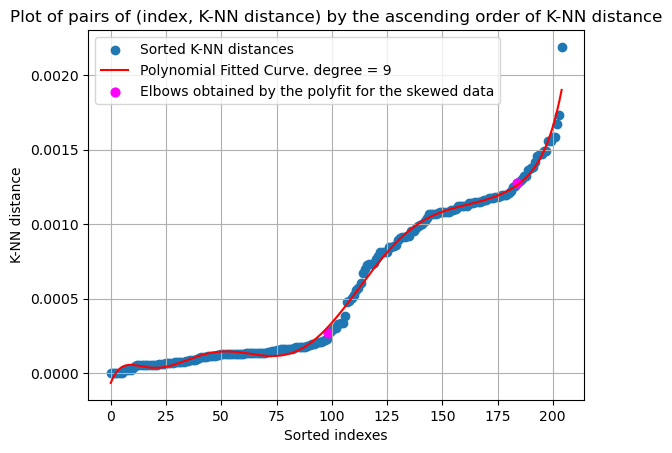

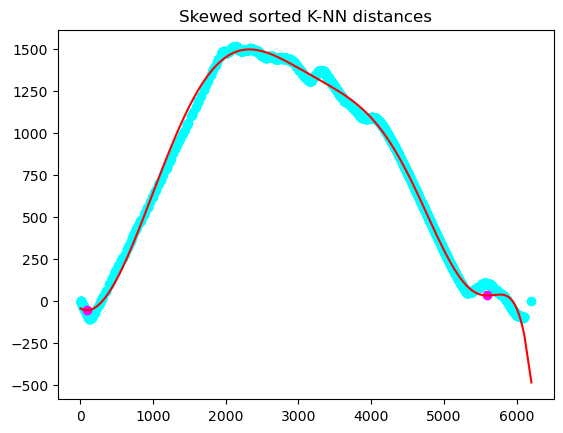

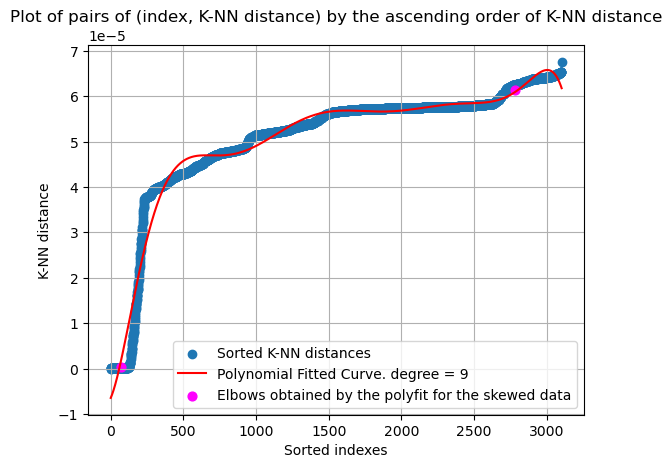

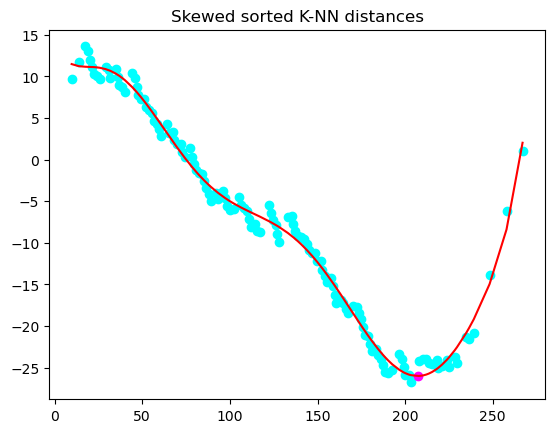

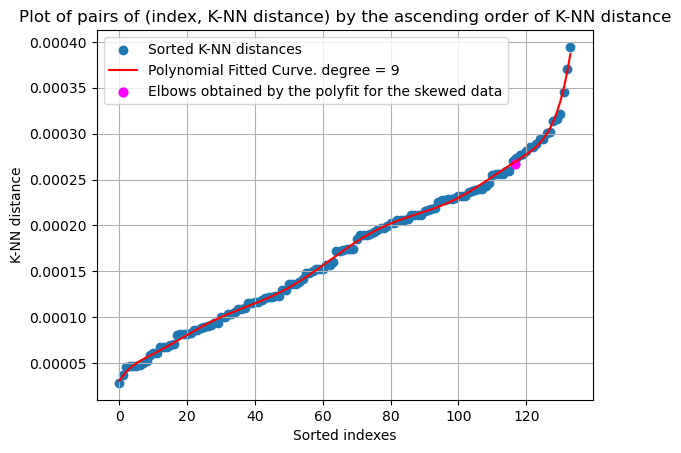

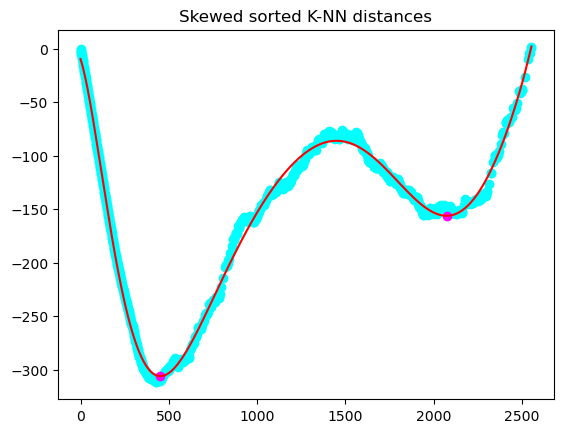

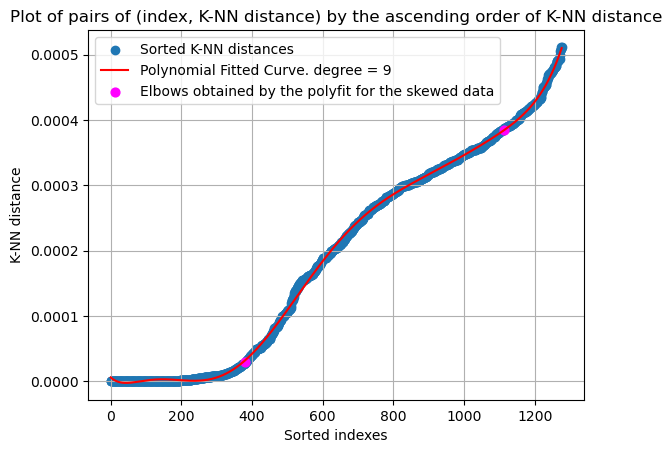

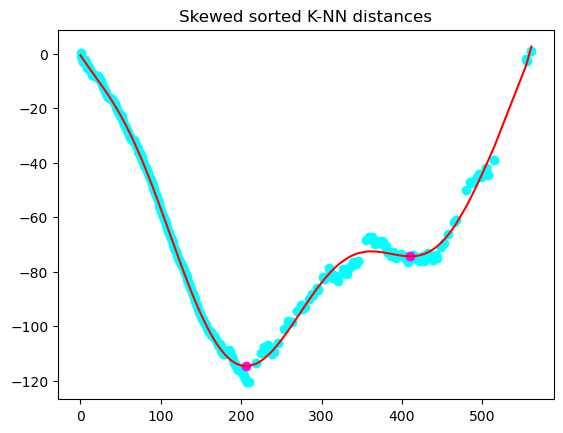

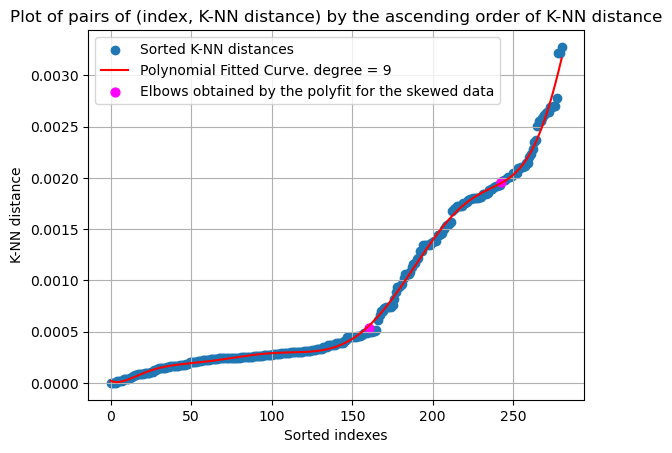

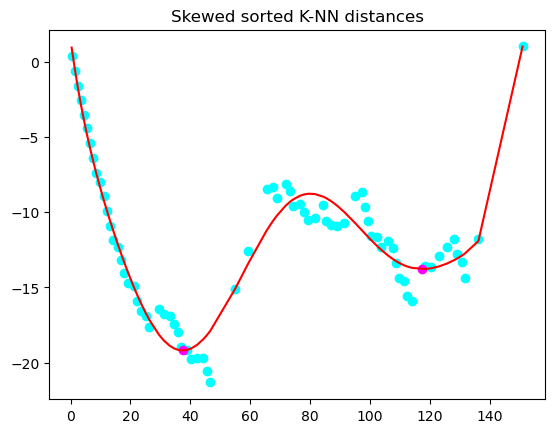

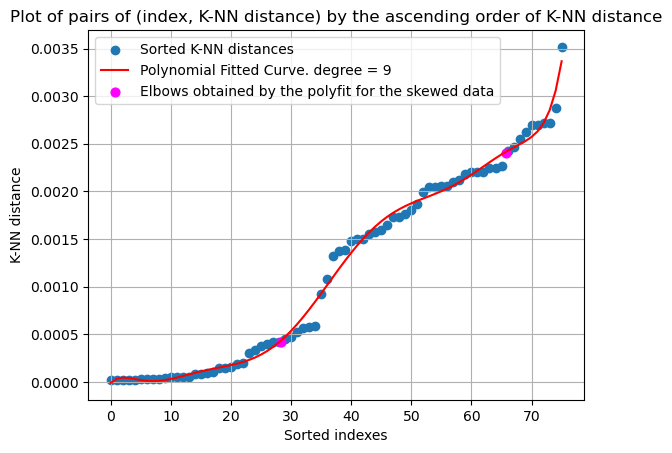

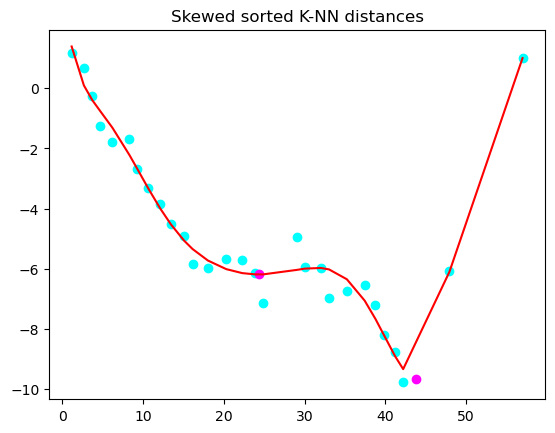

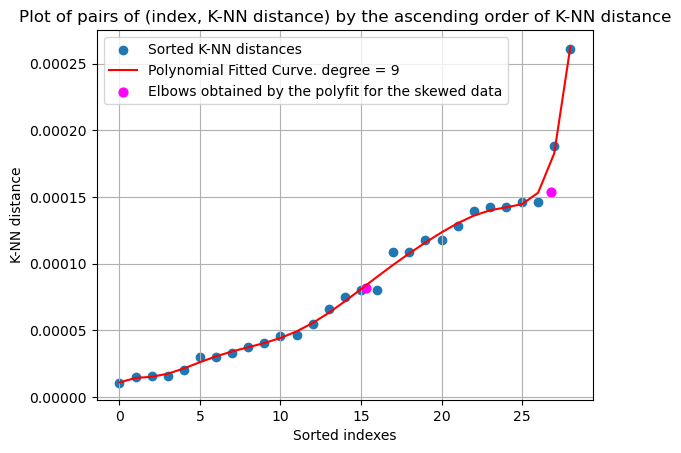

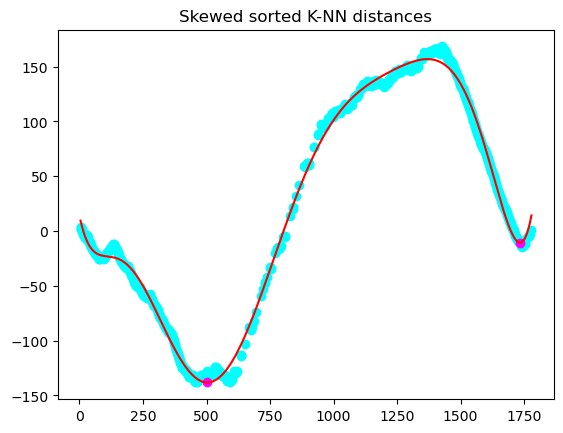

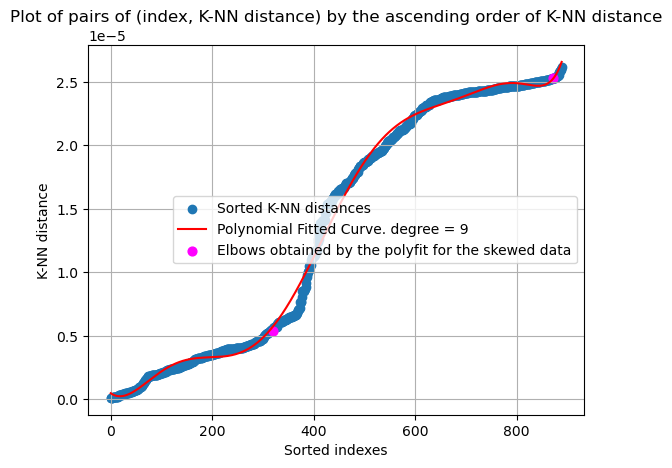

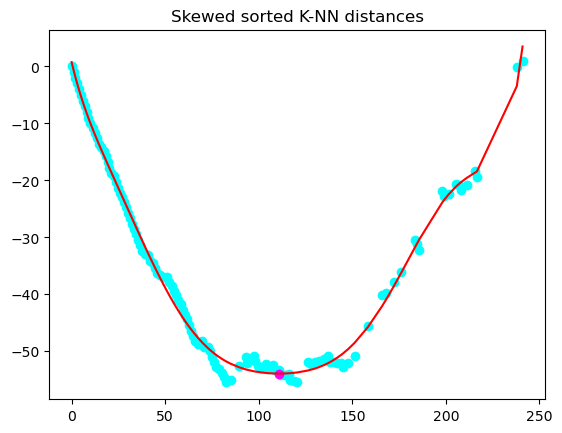

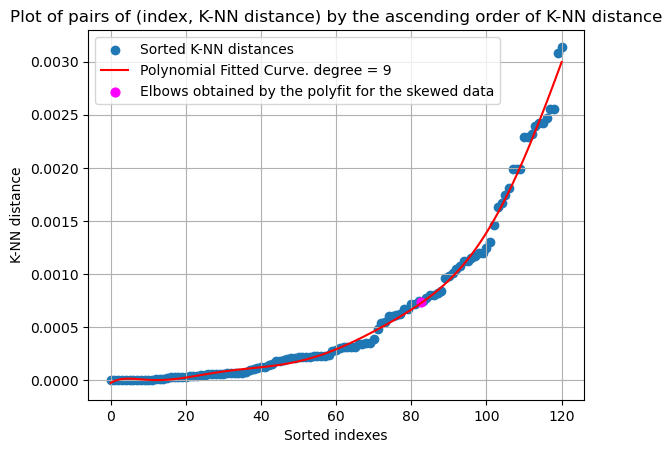

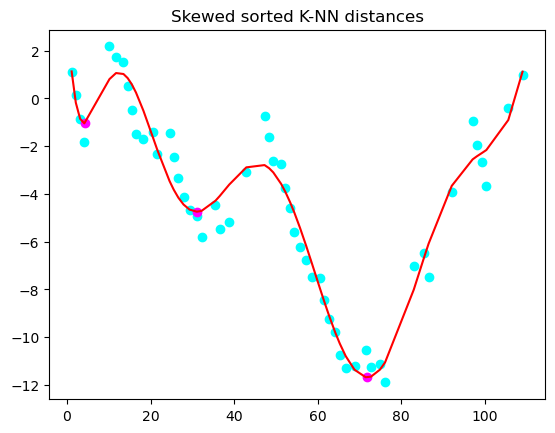

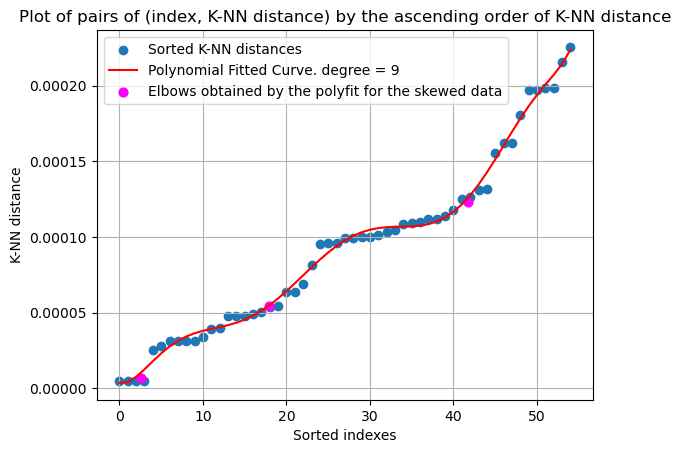

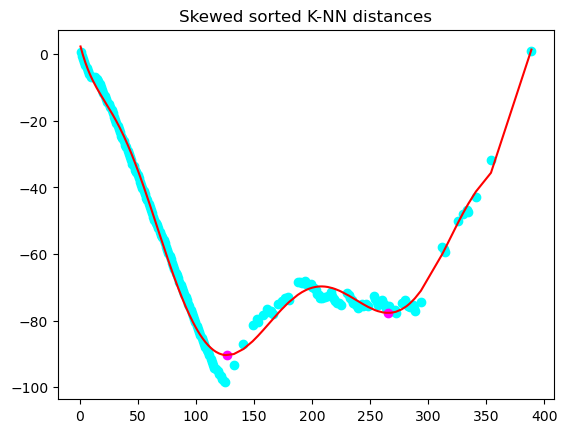

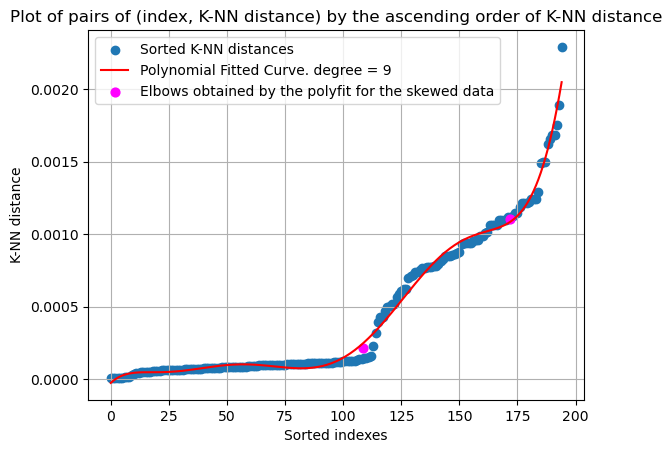

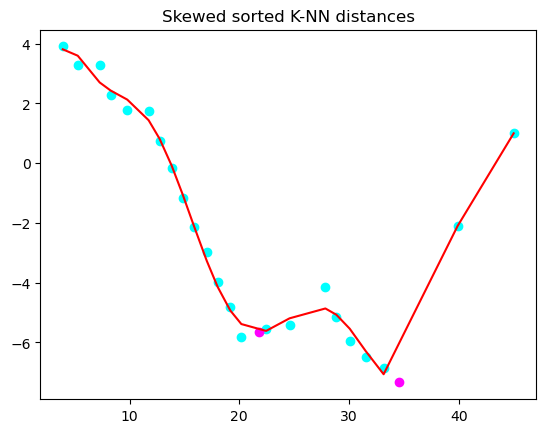

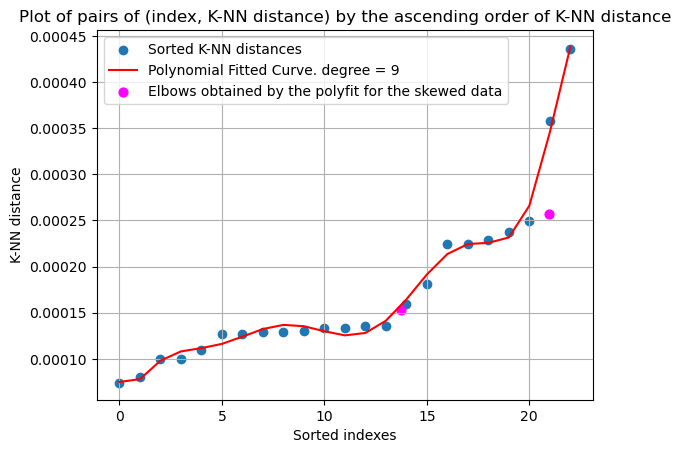

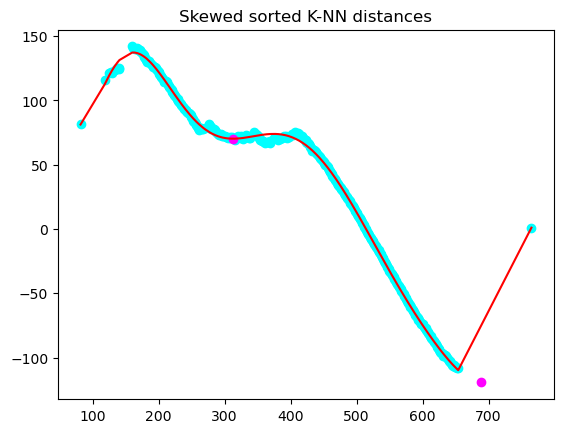

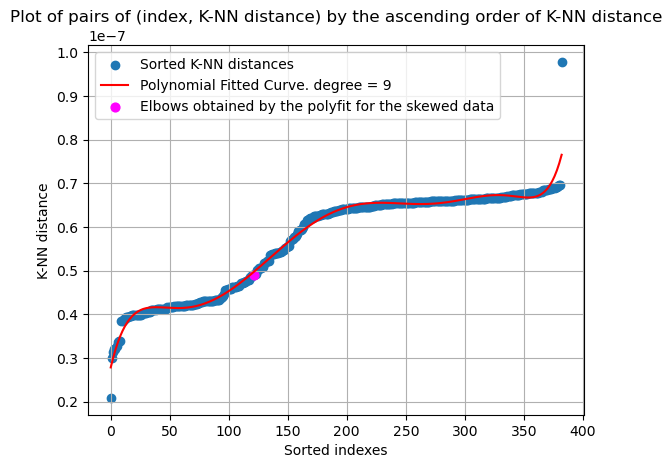

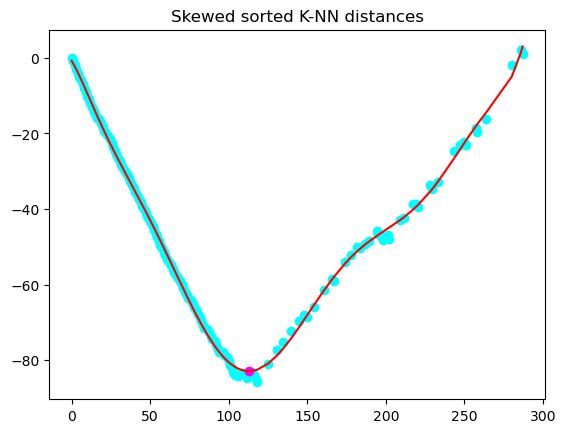

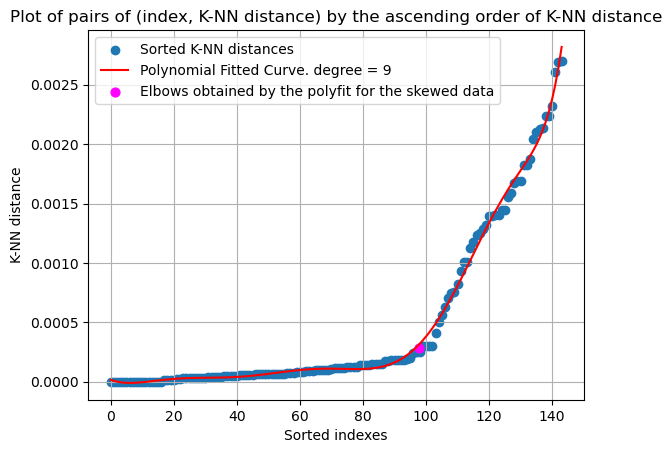

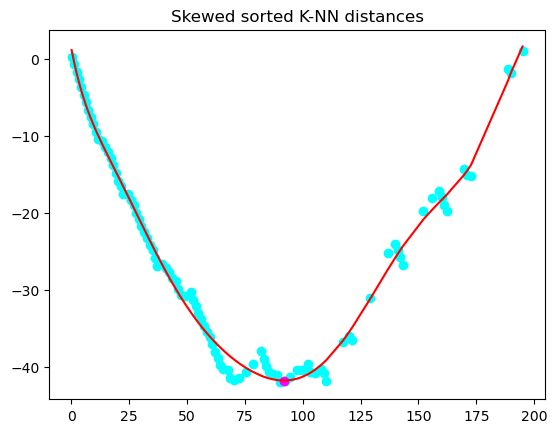

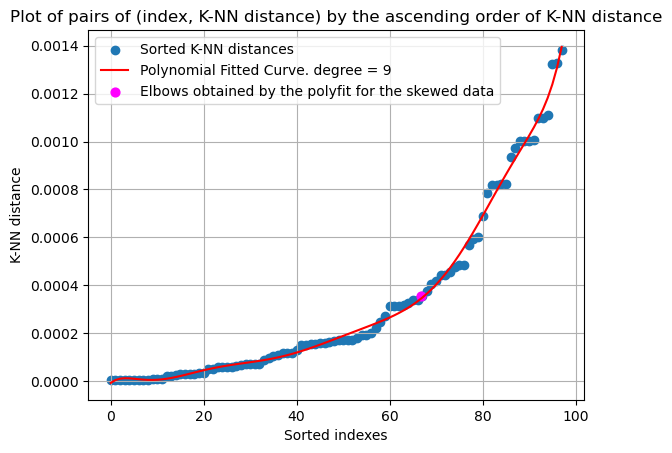

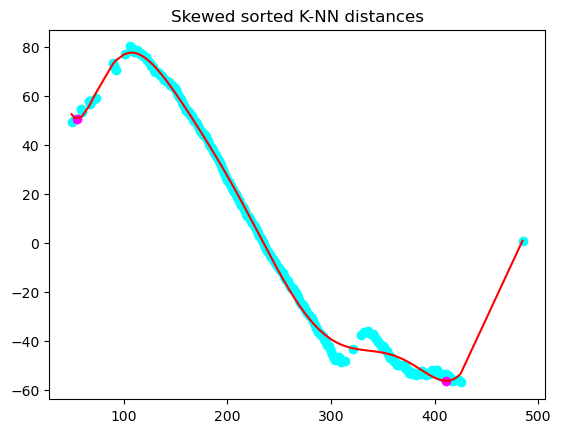

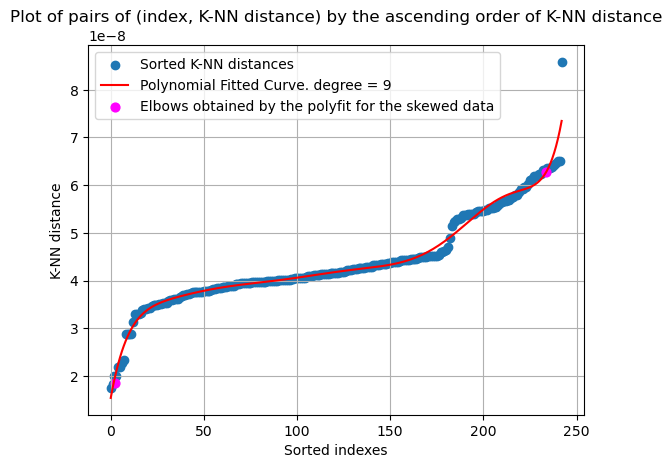

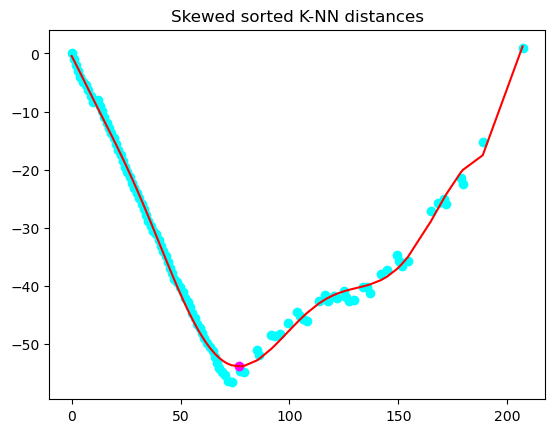

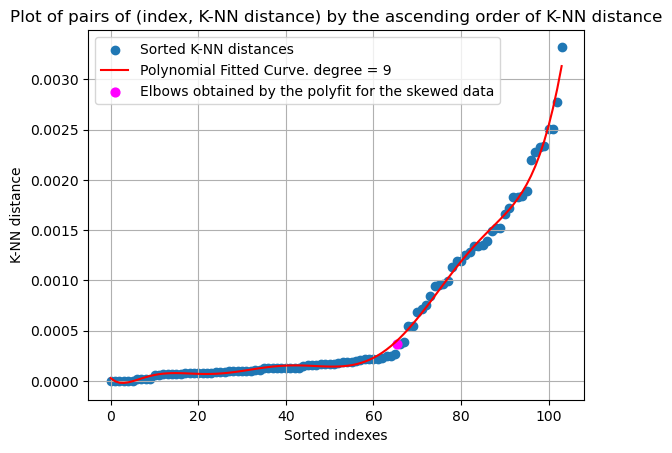

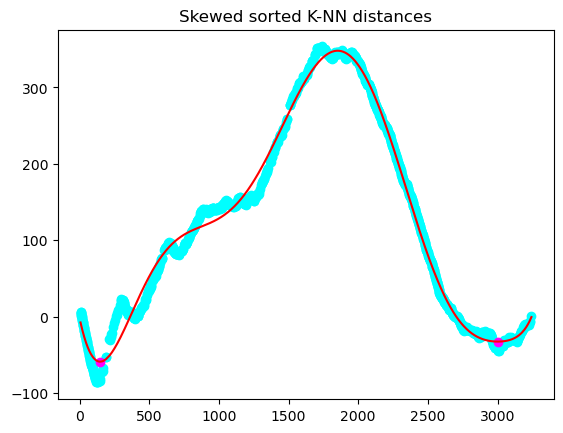

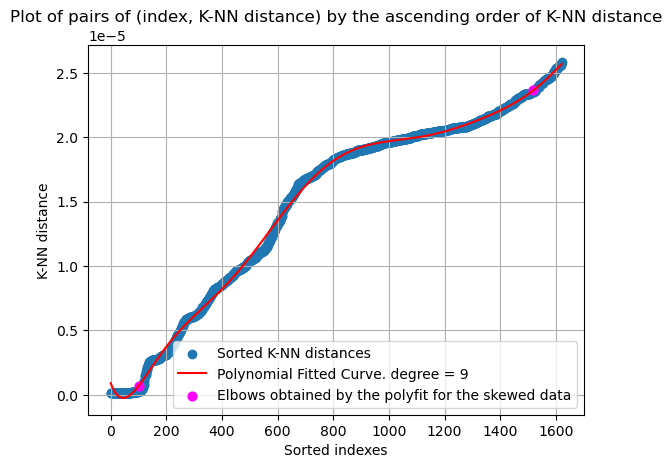

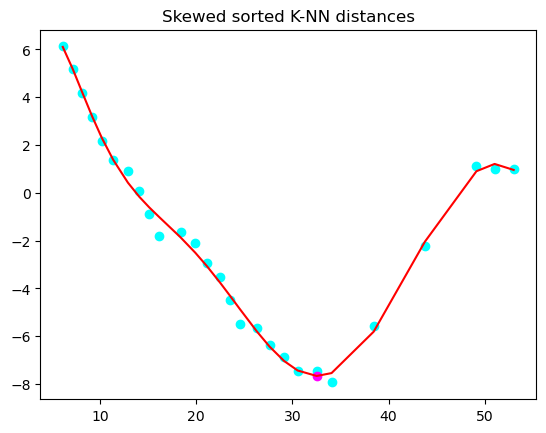

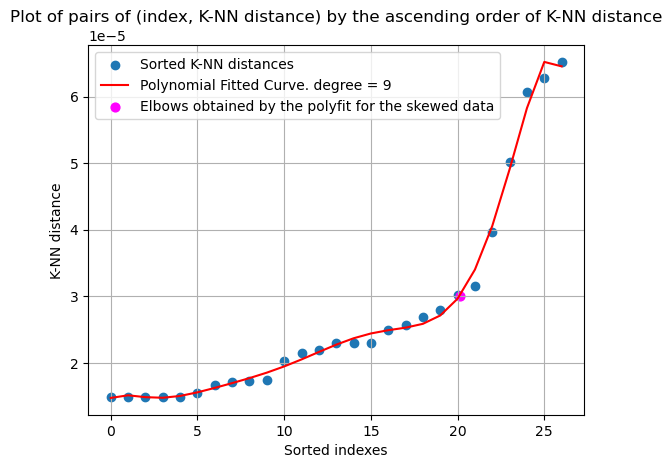

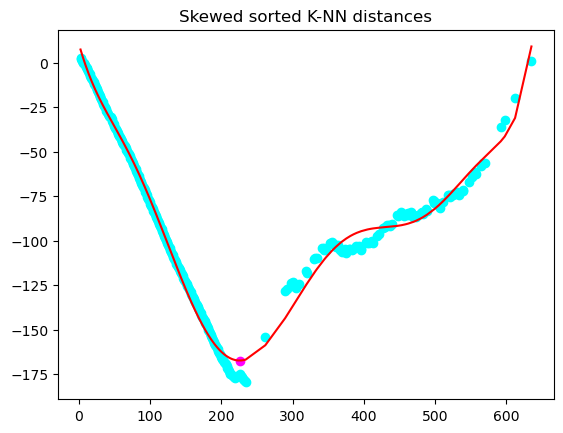

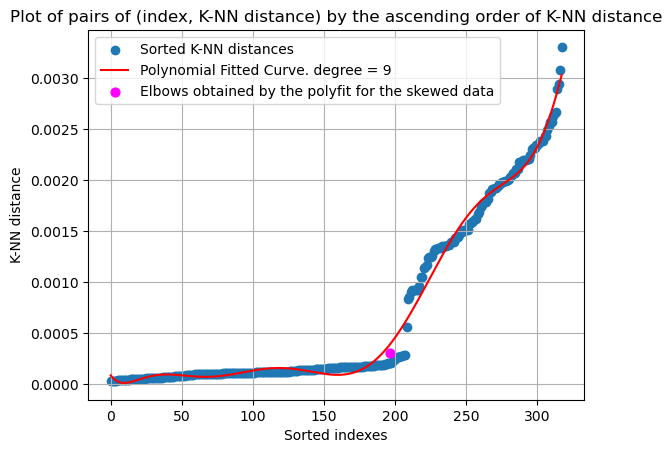

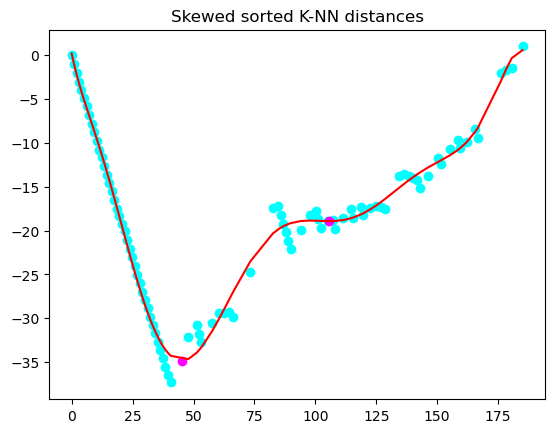

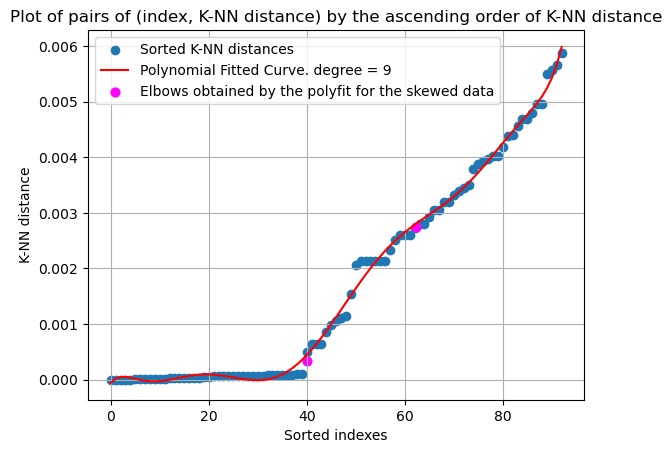

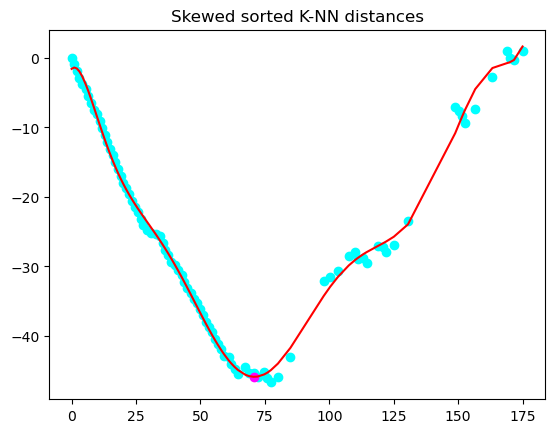

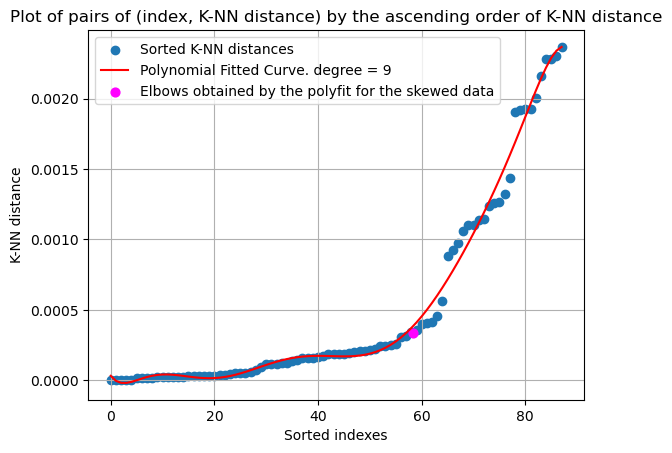

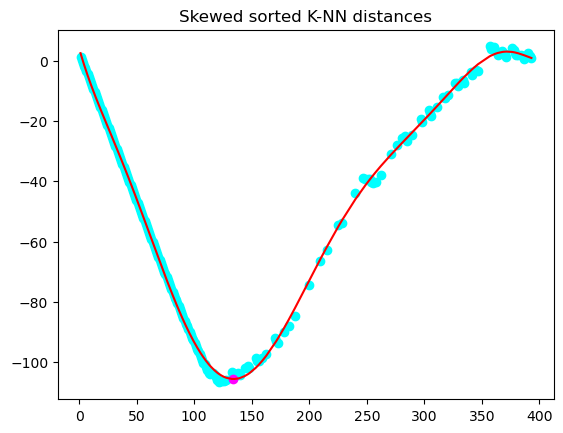

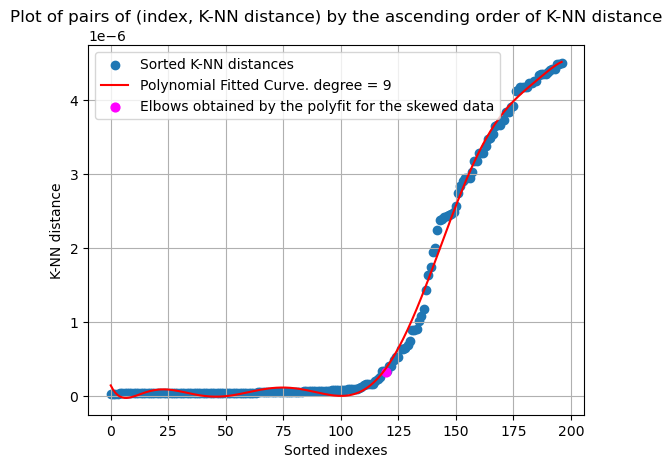

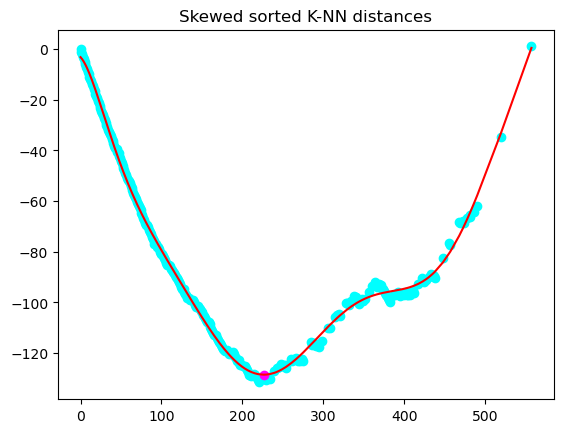

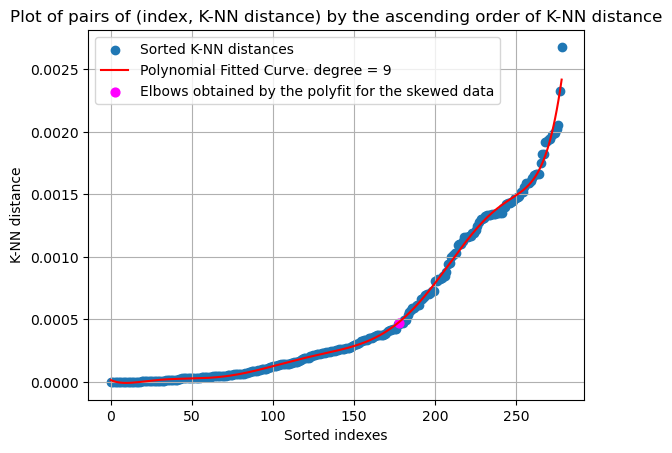

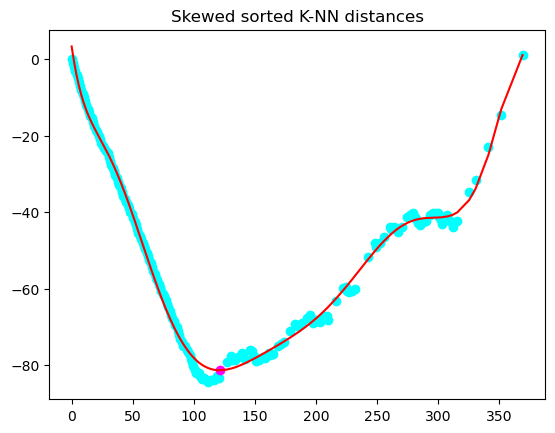

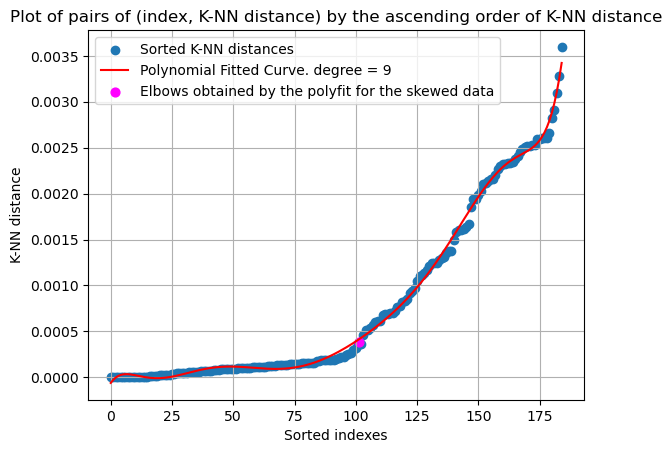

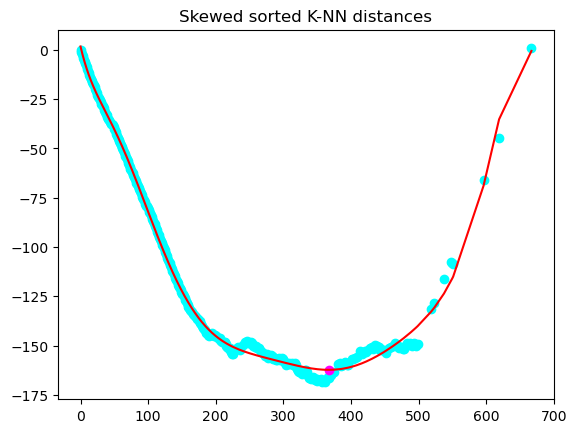

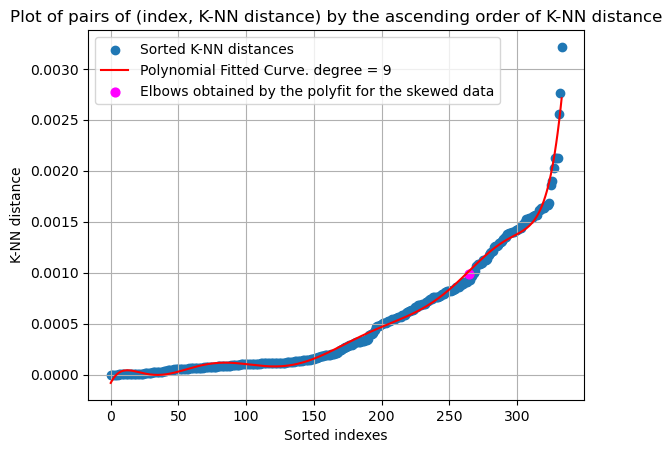

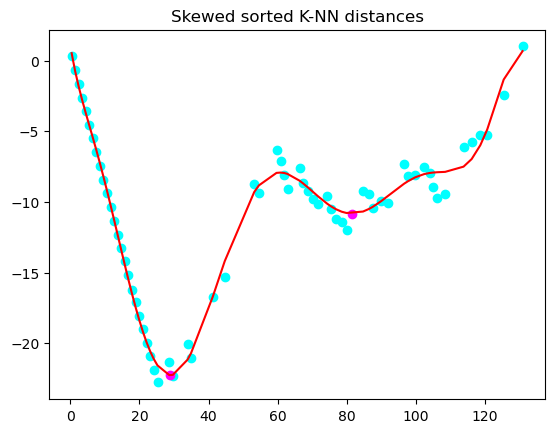

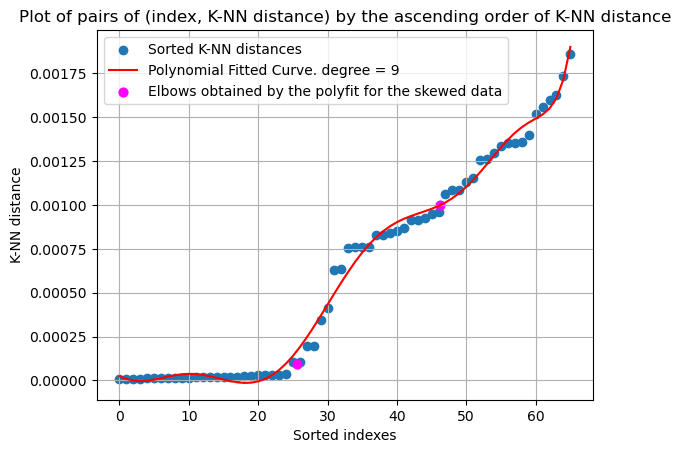

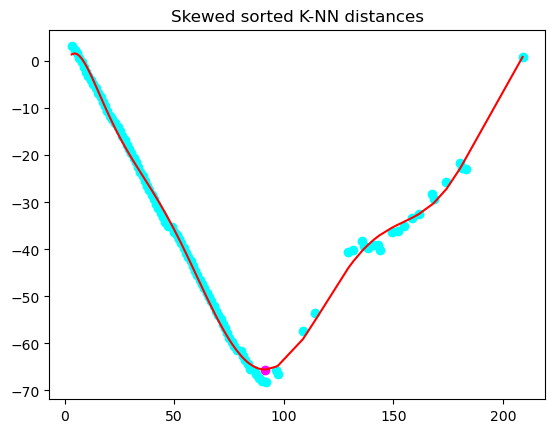

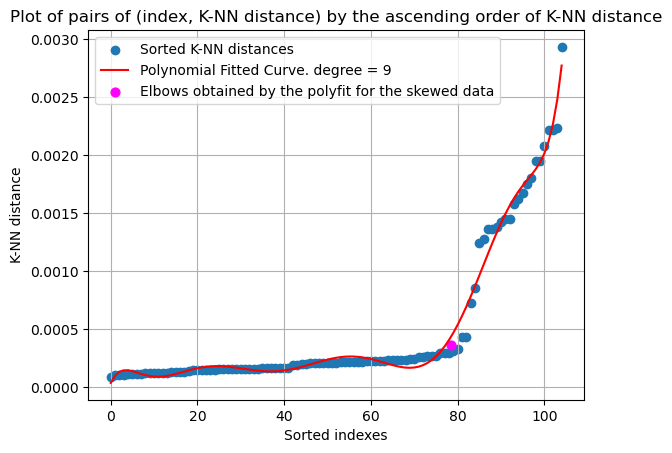

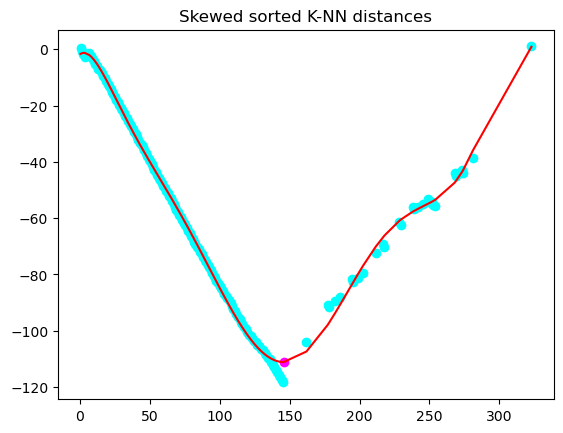

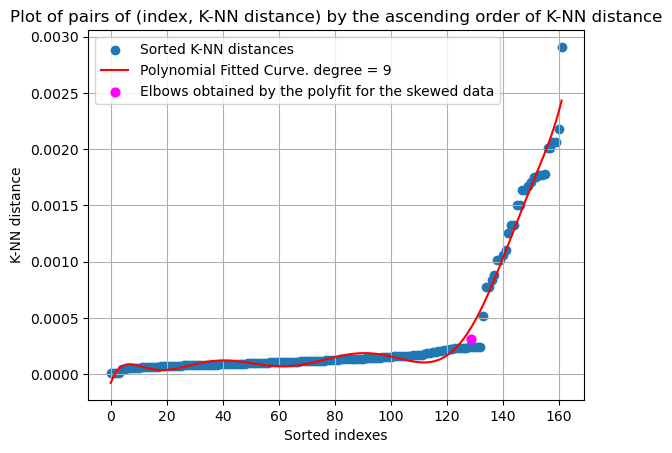

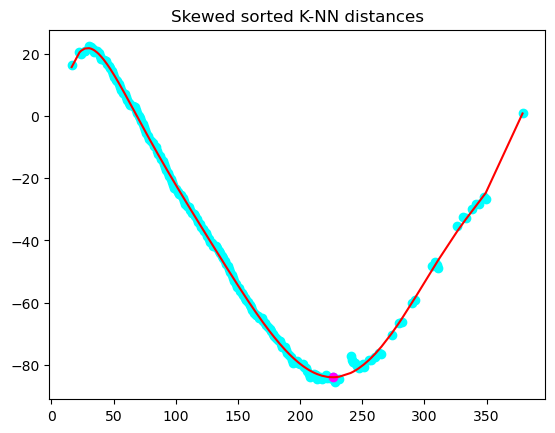

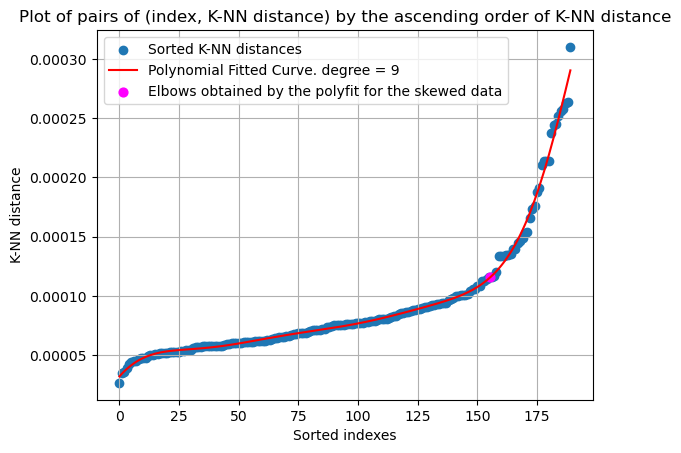

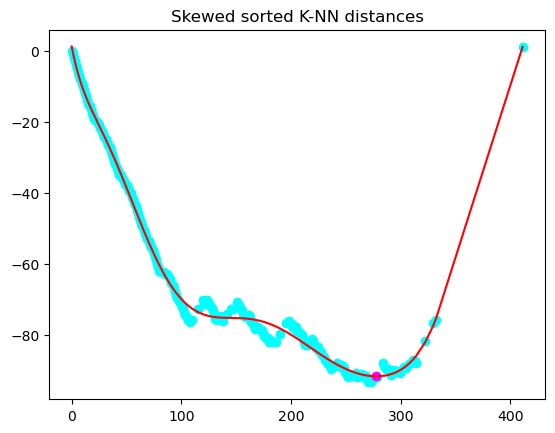

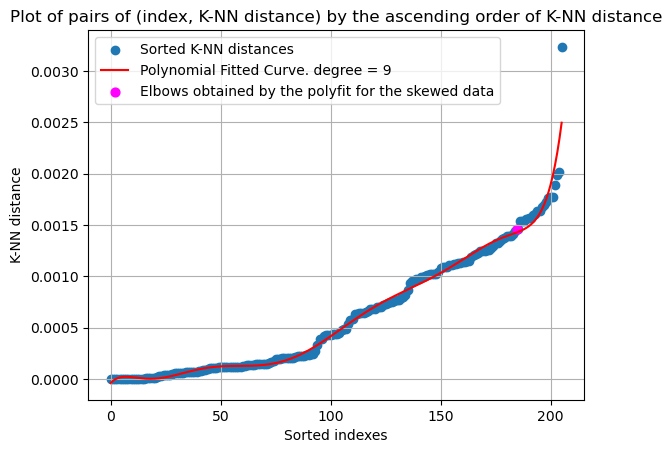

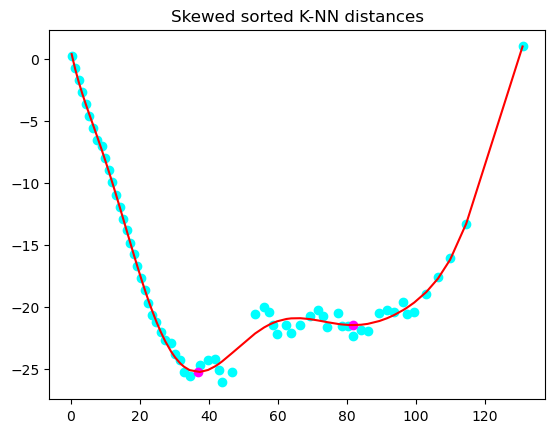

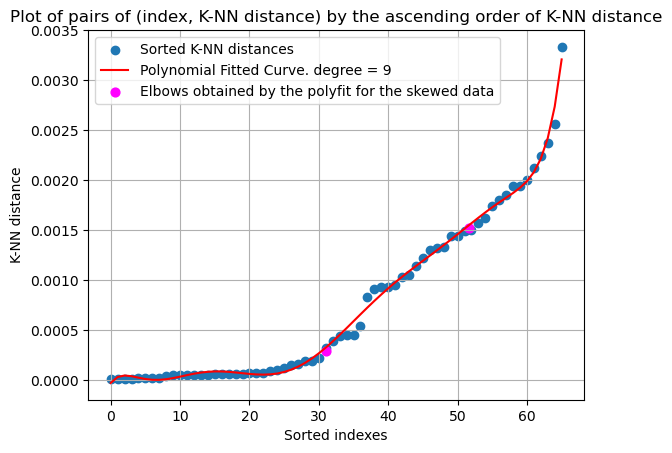

In [31]:
import os
import urllib.parse
import xml.etree.ElementTree as ET

import gpxpy
import gpxpy.gpx
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.cluster import DBSCAN
from tqdm.notebook import tqdm


def to_points(trajectory):
    """
    Convert trajectory points into a vector (I have to check the type) of points

    Args:
        trajectory: a GeoDataFrame represents trajectory points

    Returns:
        pandas.core.series.Series: a series of points representing trajectory points
    """
    return trajectory["geometry"].apply(lambda point: [point.x, point.y])


def max_distance(gdf):
    """
    Calculate the maximum distance of points of a GeoDataFrame

    Args:
        gdf: A GeoDataFrame with Points being the geometry column's type

    Returns:
        float: the maximum distance of points
    """

    # Extract coordinates from Point geometries
    coordinates = to_points(gdf)

    # Calculate maximum distance
    max_distance = 0

    for i in range(len(coordinates)):
        for j in range(i + 1, len(coordinates)):
            distance = Point(coordinates[i]).distance(Point(coordinates[j]))
            max_distance = max(max_distance, distance)

    return max_distance


def min_distance(gdf):
    """
    Calculate the minimum distance of points of a GeoDataFrame

    Args:
        gdf: A GeoDataFrame with Points being the geometry column's type

    Returns:
        float: the minimum distance of points
    """

    # Extract coordinates from Point geometries
    coordinates = to_points(gdf)

    # Calculate minimum distance
    min_distance = 1000000  # TODO: change this constant to a more proper value (can we get the maximum value in float type in Python?)

    for i in range(len(coordinates)):
        for j in range(i + 1, len(coordinates)):
            distance = Point(coordinates[i]).distance(Point(coordinates[j]))
            min_distance = min(min_distance, distance)

    return min_distance


# TODO: research good ways to decide eps and min_samples.
def trajectory_DBSCAN(trajectory, eps=0.1, min_samples=3):
    """
    Cluster trajectory points using the DBSCAN algorithm.

    Args:
        trajectory: A GeoDataFrame represents trajectry points
        eps: the radius of the circle used in the DBSCAN algorithm
        min_samples: the threhold used in the DBSCAN algorithm. If the number of points inside the eps-circle is greater than or equal to min_samples, then the ponit is marked as core point.

    Returns:
        numpy.ndarray: the result of clustering
    """
    points = to_points(trajectory).tolist()

    # Perform DBSCAN clustering
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(points)
    return labels


def read_file_content(file_path):
    with open(file_path, "r") as file:
        content = file.read()
    return content


def load_GPStrace_from_OSM(id, save_local=True):
    """
    Download a GPS trace from Open Street Map, or load it from the local storage in case there exists the cache.

    Args:
        id: the id of the GPS trace data. For example, "8504293" in https://www.openstreetmap.org/user/sunnypilot/traces/8504293
        save_local: if True, then the GPS trace data is save as GPX into the local storage when the request was successful

    Returns:
        Optional[GPX]: the GPX data of the GPS trace (Note: None is returned when the request failed)
    """

    cache_dir = "osm-gps-trace-cache"
    cache_path = os.path.join(cache_dir, f"OSM-GPSTrace-{id}")

    if os.path.isfile(cache_path):
        return GPX_to_GeoDataFrame(gpxpy.parse((read_file_content(cache_path))))

    base_url = "https://www.openstreetmap.org/trace/"
    url = urllib.parse.urljoin(base_url, f"{id}/data")
    response = requests.get(url)

    if response.status_code == 404:
        return None

    with open(cache_path, "w") as file:
        file.write(response.text)

    return GPX_to_GeoDataFrame(gpxpy.parse(response.text))


def GPX_to_GeoDataFrame(gpx):
    """
    Convert GPX into GeoDataFrame

    Args:
        gpx: GPX data

    Returns:
        GeoDataFrame: A GeoDataFrame of the GPX data
    """

    data = {"geometry": [], "time": [], "elevation": []}
    for segment in gpx.tracks[0].segments:
        for p in segment.points:
            data["geometry"].append(Point(p.longitude, p.latitude))
            data["time"].append(p.time)
            data["elevation"].append(p.elevation)
    return gpd.GeoDataFrame(data=data, geometry="geometry")


def knn_distance(gdf, point_index, k):
    # Calculate kNN distance
    point = gdf.geometry.iloc[point_index]
    return gdf.geometry.distance(point).sort_values().iloc[k]


def skew(x, y, W, H):
    c = W / H
    skewed_xy = [(xy[0] + c * xy[1], -xy[0] + c * xy[1]) for xy in zip(x, y)]
    x2 = [xy[0] for xy in skewed_xy]
    y2 = [xy[1] for xy in skewed_xy]
    return (x2, y2)


def inv_skew(x, y, W, H):
    c = W / H
    inv_skewed_xy = [
        (xy[0] / 2 - xy[1] / 2, xy[0] / (2 * c) + xy[1] / (2 * c)) for xy in zip(x, y)
    ]
    x2 = [xy[0] for xy in inv_skewed_xy]
    y2 = [xy[1] for xy in inv_skewed_xy]
    return (x2, y2)


def draw_polynomial_fitting(x, y, degree):
    # Perform polynomial fitting
    coefficients = np.polyfit(x, y, degree)

    # Generate fitted polynomial curve
    y_fit = np.polyval(coefficients, x)
    plt.plot(x, y_fit, color="red", label=f"Polynomial Fitted Curve. degree = {degree}")


def draw_local_minimals(x, y, degree):
    # Perform polynomial fitting
    coefficients = np.polyfit(x, y, degree)

    # Find the local minimal_s
    min_x = np.min(x)
    max_x = np.max(x)
    local_minimal_x, local_minimal_y = local_minimals(coefficients, min_x, max_x)

    # Plot
    plt.scatter(
        local_minimal_x,
        local_minimal_y,
        color="Magenta",
        label=f"Local Minimals. degree = {degree}",
    )


def local_minimals(coefficients, min_x, max_x):
    # Calculate the first derivative of the polynomial
    derivative = np.polyder(coefficients, 1)

    # Find the local minimal points
    roots = [root for root in np.roots(derivative) if np.isreal(root)]

    # Find the local minimum points which are inside the domain
    local_minimal_x = [
        x
        for x in roots
        if np.polyval(derivative, x - 1e-5) < 0
        and np.polyval(derivative, x + 1e-5) > 0
        and min_x <= x
        and x <= max_x
    ]
    local_minimal_y = np.polyval(coefficients, local_minimal_x)
    return (local_minimal_x, local_minimal_y)


def skewed_minimals(x, y, W, H, degree):
    # Skew the data points
    skewed_x, skewed_y = skew(x, y, W, H)

    # Perform polynomial fitting for the skewed pairs
    coefficients = np.polyfit(skewed_x, skewed_y, degree)

    # Find the local minimum points of the fitting polynomial which are inside the domain of the skewed plot
    min_x = np.min(skewed_x)
    max_x = np.max(skewed_x)
    local_minimal_x, local_minimal_y = local_minimals(coefficients, min_x, max_x)

    # Extract points which are in the domain of the original plot
    original_x, original_y = inv_skew(local_minimal_x, local_minimal_y, W, H)
    original_xy = [
        (xy[0], xy[1]) for xy in zip(original_x, original_y) if 0 <= xy[0] and xy[0] < W
    ]
    result_x = [xy[0] for xy in original_xy]
    result_y = [xy[1] for xy in original_xy]
    return (result_x, result_y)


def plot_skewed(x, y, W, H, extremums_x, extremums_y, degree):
    skewed_x, skewed_y = skew(x, y, W, H)
    plt.scatter(skewed_x, skewed_y, label="Skewed sorted K-NN distances", color="cyan")
    plt.title("Skewed sorted K-NN distances")
    draw_polynomial_fitting(skewed_x, skewed_y, degree)
    draw_local_minimals(skewed_x, skewed_y, degree)
    plt.show()


latest_id = 8000000  # 8487896
num_of_retrieved_traces = 32
for i in tqdm(range(num_of_retrieved_traces)):
    # Down load a GPS trace from Open Street Map
    id = latest_id - i
    gdf = load_GPStrace_from_OSM(id)
    if gdf is None:
        print(f"skipped {url}")
        continue

    # Compute the points for the k-NN distance plot
    k = 3
    knn_distances = []
    for i in range(len(gdf)):
        knn_distances.append(knn_distance(gdf, i, k))
    sorted_knn_distances = sorted(knn_distances)
    x = range(len(sorted_knn_distances))

    # The degree for polynomial fitting
    degree = 9

    # Find the "elbows" in the skewed graph
    minimals_x, minimals_y = skewed_minimals(
        x, sorted_knn_distances, len(x), max(sorted_knn_distances), degree
    )

    # Plot the skwewed data
    plot_skewed(
        x,
        sorted_knn_distances,
        len(x),
        max(sorted_knn_distances),
        minimals_x,
        minimals_y,
        degree,
    )

    # Plot the original data
    plt.scatter(x, sorted_knn_distances, label="Sorted K-NN distances")
    plt.xlabel("Sorted indexes")
    plt.ylabel("K-NN distance")
    plt.title(
        "Plot of pairs of (index, K-NN distance) by the ascending order of K-NN distance"
    )
    plt.grid(True)
    draw_polynomial_fitting(
        x, sorted_knn_distances, degree
    )  # Draw the polynomial fitting for the original data
    plt.scatter(
        minimals_x,
        minimals_y,
        s=40,
        color="Magenta",
        label="Elbows obtained by the polyfit for the skewed data",
    )
    plt.legend()
    plt.show()


#     # Clustering
#     eps = min_distance(gdf) * 1.5
#     if eps == 0.0:
#         eps = max_distance(gdf) / (
#             2 * len(gdf)
#         )  # this is kind of random, but I want to avoid eps being 0.0 anyway
#     gdf["cluster"] = trajectory_DBSCAN(
#         gdf, eps=eps, min_samples=5
#     )  # eps = 0.00000000000002

#     # Plot
#     plot_trajectory(
#         gdf,
#         f"A GPS trace from OSM (id = {id})",
#         plot_trajectory_edges=False,
#         plot_clusters=True,
#     )